# RGB to Wavelength
Experiments on converting RGB values from PL images to wavelengths.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [7]:
# load the raw quantum efficiency data
# first column is wavelength in nm
# remaining columns are the %QE of the color sensor
qe_df = pd.read_csv('../frgtrainview/analysis/CS165CU_Quantum_Efficiency.csv', header=2).dropna()
qe_df

,Wavelength (nm),Blue,Green,Red
0,400.0,29.08381,5.51529,6.85800
1,405.0,33.02385,5.05232,6.01200
2,410.0,36.23982,4.56168,5.20900
3,415.0,39.10839,4.11991,4.55300
4,420.0,41.53590,3.74965,4.06200
...,...,...,...,...
116,980.0,4.57946,4.23049,4.39953
117,985.0,4.16327,3.84786,4.01697
118,990.0,3.77307,3.49821,3.67050
119,995.0,3.38447,3.15649,3.33007


In [26]:
# normalize the RGB columns by their individual min and max QE
# ie min blue QE = 0, max blue QE = 255

rgb_table = pd.DataFrame()
rgb_table['Wavelength'] = qe_df['Wavelength (nm)']

for c in ['Blue', 'Green', 'Red']:
    qe_min = qe_df[c].min()
    qe_max = qe_df[c].max()

    x = (qe_df[c] - qe_min)/(qe_max - qe_min) * 255
    rgb_table[c] = x

rgb_table

,Wavelength,Blue,Green,Red
0,400.0,134.471677,10.686089,22.005288
1,405.0,153.570296,8.788259,18.473421
2,410.0,169.159120,6.777003,15.121069
3,415.0,183.063986,4.966077,12.382410
4,420.0,194.830894,3.448289,10.332591
...,...,...,...,...
116,980.0,15.691344,5.419373,11.741706
117,985.0,13.673940,3.850877,10.144601
118,990.0,11.782517,2.417574,8.698163
119,995.0,9.898850,1.016778,7.276941


In [110]:
# determine wavelength that maps "best" to a given rgb point
# based on lowest distance between the rgb points
# TODO: maybe QE curve interpolation to get finer wavelength data?

x = (200, 100, 20)

def distance(rgb1, rgb2):
    # use squared euclidean distance
    return np.sum(np.square(rgb1 - rgb2), axis=-1) # axis=-1 to vectorize

print(np.array([x] * 100).shape)
print(distance(np.array([x] * 100), x))

# closest = rgb_table[['Blue', 'Green', 'Red']].apply(lambda row: distance(x, row), axis=1).nsmallest(1)
# closest.name = 'distance'
# temp = rgb_table.loc[closest.index]
# temp = temp.join(closest)
# temp

(100, 3)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [120]:
rgb_table_arr = rgb_table[['Red', 'Green', 'Blue']].to_numpy()

def rgb_to_wavelength(rgb, distance_func=distance):
    closest = np.argmin(distance_func(rgb_table_arr, rgb))

    return rgb_table['Wavelength'].loc[closest]

In [123]:
rgb_to_wavelength((0, 100, 200))

475.0

In [124]:
%%timeit
rgb_to_wavelength((0, 100, 200))

23.6 µs ± 2.01 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [85]:
from frgpascal.analysis.processing import load_all
from natsort import index_natsorted

def load_all_sorted(chardir):
	metricdf, rawdf = load_all(
		chardir,
		t_kwargs=dict(
			wlmin=700,
			wlmax=900
		)
	)
	rawdf= rawdf.sort_values(
   		by='name',
   		key=lambda x: np.argsort(index_natsorted(rawdf['name']))
    )
	rawdf = rawdf.reset_index(drop=True)


	metricdf= metricdf.sort_values(
    	by='name',
    	key=lambda x: np.argsort(index_natsorted(metricdf['name']))
    )
	metricdf = metricdf.reset_index(drop=True)
	return metricdf, rawdf

In [86]:
# load the images
chardir = '../data/output/20221027_B13-char/Characterization'
_, rawdf = load_all_sorted(chardir)

Loading data:   0%|          | 0/32 [00:00<?, ?sample/s]/home/kcw/miniconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:105: RuntimeWarning: invalid value encountered in log10
  a = -np.log10(t)
Loading data:   6%|▋         | 2/32 [00:01<00:20,  1.47sample/s]/home/kcw/miniconda3/envs/fenning/lib/python3.7/site-packages/frgpascal/analysis/processing.py:105: RuntimeWarning: divide by zero encountered in log10
  a = -np.log10(t)
Loading data: 100%|██████████| 32/32 [00:22<00:00,  1.42sample/s]


In [125]:
import cv2

pl = rawdf['plimg_0'].apply(lambda x: np.uint8(x * 255)) # convert to 0-255 and downsample
pl.head(1)

0    [[[254, 178, 44], [254, 176, 45], [254, 183, 0...
Name: plimg_0, dtype: object

(1080, 1440, 3)
(1080, 1440)


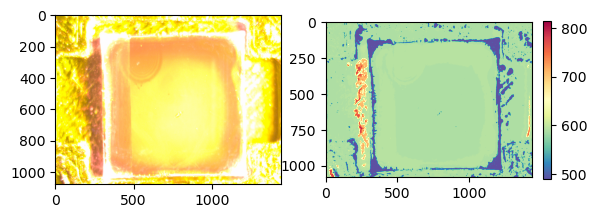

In [132]:
i=0

print(pl[i].shape)
wl = np.apply_along_axis(rgb_to_wavelength, 2, pl[i]) # TODO: vectorize
print(wl.shape)
fig, ax = plt.subplots(1,2)
ax[0].imshow(pl[i])
im = ax[1].imshow(wl, cmap=plt.cm.Spectral_r)
plt.colorbar(im, ax = ax[1], fraction = 0.035)